<a href="https://colab.research.google.com/github/manuflores/fishing_classification_project/blob/main/classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -q numpy pandas matplotlib seaborn geopy scikit-learn xgboost

In [22]:
"""
Fishing classification using Scikit-learn.
"""

import argparse
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
%config InlineBackend.figure_format="retina"
sns.set_style("white")

def create_time_windowed_data(df: pd.DataFrame, window_size: int = 10) -> pd.DataFrame:
    """
    Create time-windowed data for feature engineering.

    Params
    ------
    - df (pd.DataFrame): Input dataframe.
    - window_size (int): Size of the time window.

    Returns
    -------
    - pd.DataFrame: Dataframe with time-windowed features.
    """
    df = df.copy()
    feature_cols = ['speed', 'course', 'latitude', 'longitude']
    for i in range(1, window_size + 1):
        for col in feature_cols:
            df[f"{col}_t-{i}"] = df.groupby('mmsi')[col].shift(i)
    return df.dropna().reset_index(drop=True)

def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Compute great-circle distance (in km) between two lat/lon points.

    Params
    ------
    - lat1 (float): Latitude of the first point.
    - lon1 (float): Longitude of the first point.
    - lat2 (float): Latitude of the second point.
    - lon2 (float): Longitude of the second point.

    Returns
    -------
    - float: Distance in meters.
    """
    if pd.notnull(lat1) and pd.notnull(lat2):
        return geodesic((lat1, lon1), (lat2, lon2)).m
    return 0

def compute_vessel_distances(group: pd.DataFrame) -> pd.DataFrame:
    """
    Compute distance for each vessel's movement history.

    Params
    ------
    - group (pd.DataFrame): Grouped dataframe for a single vessel.

    Returns
    -------
    - pd.DataFrame: Dataframe with computed distances.
    """
    latitudes = group['latitude'].values
    longitudes = group['longitude'].values
    distances = [0]  # First entry has no previous point to compare to

    for i in range(1, len(latitudes)):
        dist = haversine_distance(latitudes[i-1], longitudes[i-1], latitudes[i], longitudes[i])
        distances.append(dist)

    group['distance'] = distances
    return group

def compute_distance_for_all_vessels(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply distance computation to each vessel separately.

    Params
    ------
    - df (pd.DataFrame): Input dataframe.

    Returns
    -------
    - pd.DataFrame: Dataframe with computed distances for all vessels.
    """
    return df.groupby('mmsi', group_keys=False).apply(compute_vessel_distances)

def compute_advanced_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute advanced features for the dataset.

    Params
    ------
    - df (pd.DataFrame): Input dataframe.

    Returns
    -------
    - pd.DataFrame: Dataframe with advanced features.
    """
    df['hour'] = df['ts_pos_utc'].dt.hour
    df['weekday'] = df['ts_pos_utc'].dt.weekday
    df['season'] = df['ts_pos_utc'].dt.month % 12 // 3  # 0: Winter, 1: Spring, 2: Summer, 3: Fall
    df['time_delta'] = df.groupby('mmsi')['ts_pos_utc'].diff().dt.total_seconds().fillna(0)

    df['speed_diff'] = df.groupby('mmsi')['speed'].diff().fillna(0)
    df['acceleration'] = df['speed_diff'] / df['time_delta'].replace(0, np.nan)  # Avoid division by zero
    df['acceleration'] = df['acceleration'].fillna(0)
    df['jerk'] = df.groupby('mmsi')['acceleration'].diff().fillna(0)

    window_size = 10
    feature_cols = ['speed', 'course', 'acceleration']
    for col in feature_cols:
        df[f'{col}_mean'] = df.groupby('mmsi')[col].rolling(window_size, min_periods=1).mean().reset_index(level=0, drop=True)
        df[f'{col}_std'] = df.groupby('mmsi')[col].rolling(window_size, min_periods=1).std().reset_index(level=0, drop=True)
        df[f'{col}_min'] = df.groupby('mmsi')[col].rolling(window_size, min_periods=1).min().reset_index(level=0, drop=True)
        df[f'{col}_max'] = df.groupby('mmsi')[col].rolling(window_size, min_periods=1).max().reset_index(level=0, drop=True)

    df['circular_variance'] = df.groupby('mmsi')['course'].rolling(10).apply(
        lambda x: np.var(np.sin(np.radians(x))) + np.var(np.cos(np.radians(x))), raw=True
    ).reset_index(level=0, drop=True)
    return df

def one_hot_encode_weekday(df: pd.DataFrame) -> pd.DataFrame:
    """
    One-hot encode the weekday column.

    Params
    ------
    - df (pd.DataFrame): Input dataframe.

    Returns
    -------
    - pd.DataFrame: Dataframe with one-hot encoded weekday.
    """
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded = encoder.fit_transform(df[['weekday']])
    df_encoded = pd.DataFrame(encoded, columns=[f"weekday_{i}" for i in range(1, 7)], index=df.index)
    return pd.concat([df.drop(columns=['weekday']), df_encoded], axis=1)

def add_speed_cluster(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add speed cluster feature using KMeans clustering.

    Params
    ------
    - df (pd.DataFrame): Input dataframe.

    Returns
    -------
    - pd.DataFrame: Dataframe with speed cluster feature.
    """
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    df['speed_cluster'] = kmeans.fit_predict(df[['speed']])
    return df

def add_previous_fishing_status(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add previous fishing status feature.

    Params
    ------
    - df (pd.DataFrame): Input dataframe.

    Returns
    -------
    - pd.DataFrame: Dataframe with previous fishing status feature.
    """
    df['previous_fishing'] = df.groupby('mmsi')['fishing'].shift(1).fillna(0).astype(int)
    return df

def perform_model_selection(models: dict, X: pd.DataFrame, y: np.ndarray, cv_folds: int = 5) -> dict:
    """
    Perform K-Fold cross-validation on multiple models and compare their performance.

    Params
    ------
    - models (dict): Dictionary of models to evaluate.
    - X (pd.DataFrame): Feature matrix.
    - y (np.ndarray): Target variable.
    - cv_folds (int): Number of folds in Stratified K-Fold cross-validation.

    Returns
    -------
    - dict: A dictionary containing mean accuracy and standard deviation for each model.
    """
    results = {}
    kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
        results[name] = (scores.mean(), scores.std())
        print(f"{name} - Cross-validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

    return results

def plot_logistic_regression_coefficients(model: LogisticRegression, feature_names: pd.Index) -> None:
    """
    Plot coefficients of a trained Logistic Regression model.

    Params
    ------
    - model (LogisticRegression): Trained Logistic Regression model.
    - feature_names (pd.Index): Feature names.
    """
    coefs = model.coef_.flatten()
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs}).sort_values(by='Coefficient')
    print(f"Top negative features LogReg:{coef_df.head(5)}")
    print(f"Top positive features LogReg:{coef_df.tail(5)}")

    coef_df = coef_df[np.abs(coef_df.Coefficient.values) > .5]

    plt.figure(figsize=(3, 4))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')
    plt.title("Logistic Regression Coefficients")
    plt.yticks(fontsize=8)
    plt.axvline(x=0, color='black', linestyle='--')
    plt.show()

def plot_feature_importance_rf(model: RandomForestClassifier, feature_names: pd.Index) -> None:
    """
    Plot feature importance from a trained RandomForest model.

    Params
    ------
    - model (RandomForestClassifier): Trained RandomForest model.
    - feature_names (pd.Index): Feature names.
    """
    importances = model.feature_importances_
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
    print(f"Top features RF:{importance_df.head(10)}")

    plt.figure(figsize=(3, 5))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
    plt.yticks(fontsize=8)
    plt.title("Random Forest Feature Importance")
    plt.show()

def plot_confusion_matrices(models: dict, X_test: np.ndarray, y_test: np.ndarray) -> None:
    """
    Plot confusion matrices for all trained models.

    Params
    ------
    - models (dict): Dictionary of trained models.
    - X_test (np.ndarray): Test feature matrix.
    - y_test (np.ndarray): Test target variable.
    """
    for name, model in models.items():
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fishing", "Fishing"])

        plt.figure(figsize=(3, 3))
        disp.plot(cmap='Blues', values_format='d')
        plt.title(f"Confusion Matrix - {name}")
        plt.show()

def visualize_all(models: dict, X_test: np.ndarray, y_test: np.ndarray, feature_names: pd.Index, df: pd.DataFrame) -> None:
    """
    Run all visualizations for interpretability analysis.

    Params
    ------
    - models (dict): Dictionary of trained models.
    - X_test (np.ndarray): Test feature matrix.
    - y_test (np.ndarray): Test target variable.
    - feature_names (pd.Index): Feature names.
    - df (pd.DataFrame): Input dataframe.
    """
    print("Generating Logistic Regression Coefficients Plot...")
    if "Logistic Regression" in models:
        plot_logistic_regression_coefficients(models['Logistic Regression'], feature_names)

    print("Generating Random Forest Feature Importance Plot...")
    if "Random Forest" in models:
        plot_feature_importance_rf(models['Random Forest'], feature_names)

    print("Generating Confusion Matrices...")
    plot_confusion_matrices(models, X_test, y_test)


In [6]:
# prompt: Add a code snippet for importing data from Drive

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
### ============== DATA PREPROCESSING & TRAINING ============== ###
print("Starting classification script...")
file_path = "drive/MyDrive/trawlers.parquet"


df = pd.read_parquet(file_path)
df = df.dropna().reset_index(drop=True)
df.drop(columns="vessel_class", inplace=True)# all are trawlers

clf_cols = list(set(df.columns) - set(("mmsi", "ts_pos_utc", "fishing")))

### ============== EVALUATE BASELINE MODEL =====================

# Select features and target variable
X = df[clf_cols]
y = df['fishing'].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Baseline model: Logistic Regression using {clf_cols} columns.")
print(f"Accuracy with baselinemodel: {accuracy:.3f}")
print("Classification report")
print(classification_rep)


Starting classification script...
Baseline model: Logistic Regression using ['longitude', 'speed', 'latitude', 'course'] columns.
Accuracy with baselinemodel: 0.568
Classification report
              precision    recall  f1-score   support

           0       0.61      0.84      0.70     33802
           1       0.36      0.14      0.20     21481

    accuracy                           0.57     55283
   macro avg       0.48      0.49      0.45     55283
weighted avg       0.51      0.57      0.51     55283



In [11]:
#### ============== FEATURE ENGINEERING ============== ###

# Convert timestamp column to datetime format
df['ts_pos_utc'] = pd.to_datetime(df['ts_pos_utc'])
df = df.sort_values(by=["mmsi", "ts_pos_utc"])
df = create_time_windowed_data(df)
df = compute_distance_for_all_vessels(df)
df = compute_advanced_features(df)
df = one_hot_encode_weekday(df)
df = add_speed_cluster(df)
df = df[~df.isnull().any(axis=1)]

<ipython-input-3-f40e687beade>:97: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('mmsi', group_keys=False).apply(compute_vessel_distances)


In [ ]:
X = df.drop(columns=['mmsi', 'ts_pos_utc', 'fishing'])
y = df['fishing'].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42, stratify=y)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


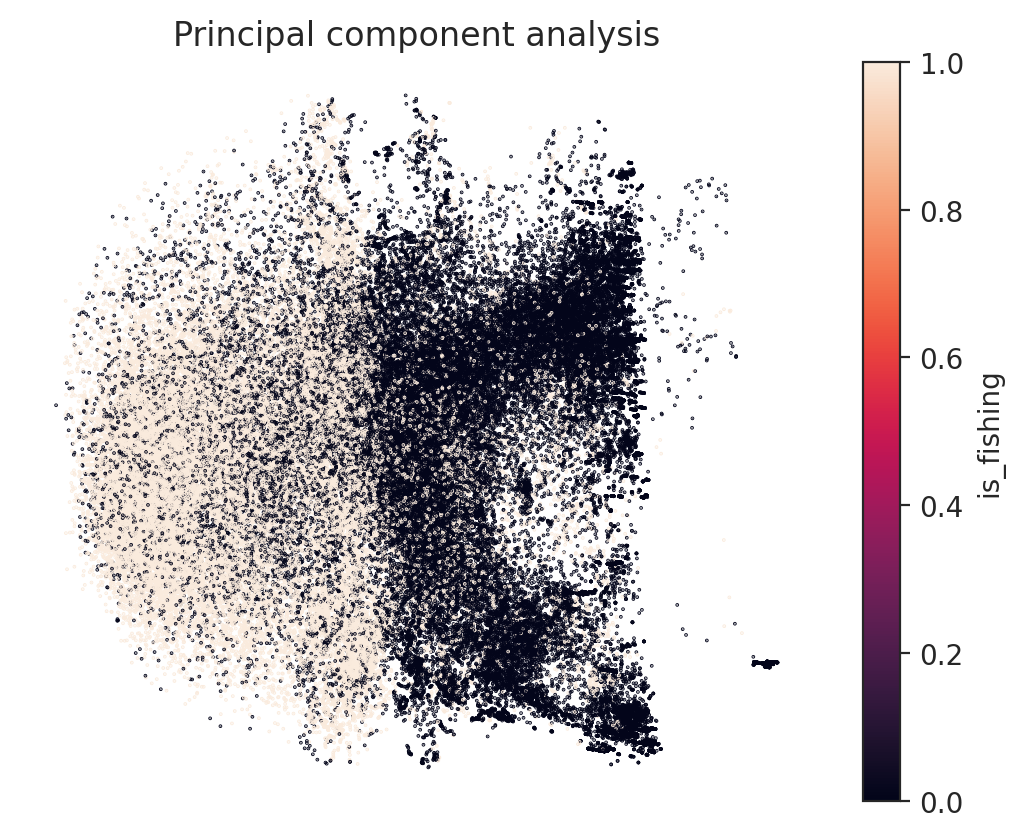

In [23]:
pcs=PCA(5).fit_transform(X_train)

plt.scatter(
    *pcs[:,(2,1)].T,s=.1, c = y_train
)


plt.axis("off")
plt.title("Principal component analysis")
plt.colorbar(label="is_fishing")

In [29]:
pd.Series(y_train[pcs[:,2]>0]).value_counts(True)

,proportion
0,0.901558
1,0.098442


In [30]:
pd.Series(y_train[pcs[:,2]<0]).value_counts(True)

,proportion
1,0.696812
0,0.303188


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Accuracy: 0.8578
              precision    recall  f1-score   support

           0       0.88      0.89      0.88     33598
           1       0.83      0.80      0.81     21415

    accuracy                           0.86     55013
   macro avg       0.85      0.85      0.85     55013
weighted avg       0.86      0.86      0.86     55013

Random Forest - Accuracy: 0.9646
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     33598
           1       0.94      0.97      0.96     21415

    accuracy                           0.96     55013
   macro avg       0.96      0.97      0.96     55013
weighted avg       0.96      0.96      0.96     55013

OOB Score: 0.9636
XGBoost - Accuracy: 0.9584
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     33598
           1       0.93      0.96      0.95     21415

    accuracy                           0.96     55013
   macro av

<ipython-input-3-f40e687beade>:224: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')


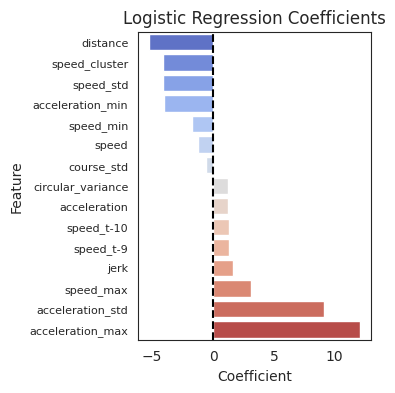

Generating Random Forest Feature Importance Plot...
Top features RF:          Feature  Importance
53      speed_min    0.101620
8       speed_t-2    0.064897
12      speed_t-3    0.063523
70  speed_cluster    0.058530
24      speed_t-6    0.050016
51     speed_mean    0.046569
20      speed_t-5    0.046221
16      speed_t-4    0.042118
32      speed_t-8    0.041203
28      speed_t-7    0.036763


<ipython-input-3-f40e687beade>:244: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')


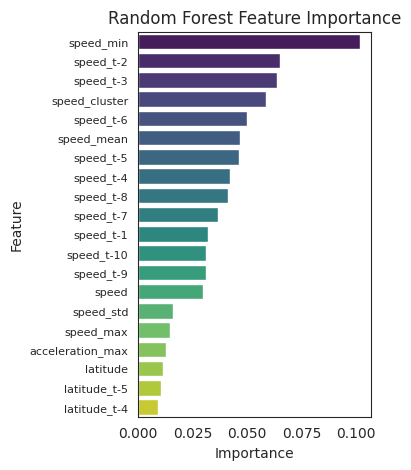

Generating Confusion Matrices...


<Figure size 300x300 with 0 Axes>

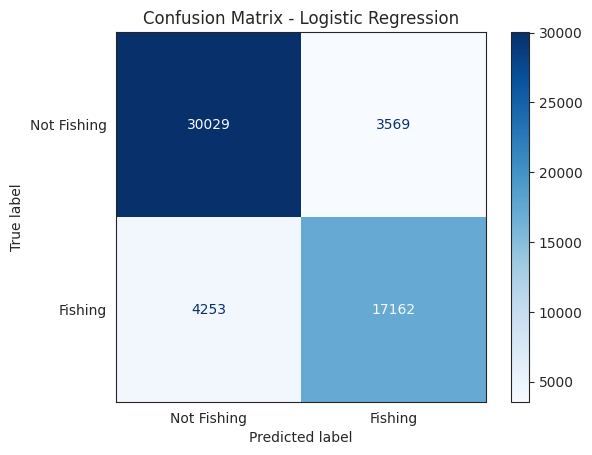

<Figure size 300x300 with 0 Axes>

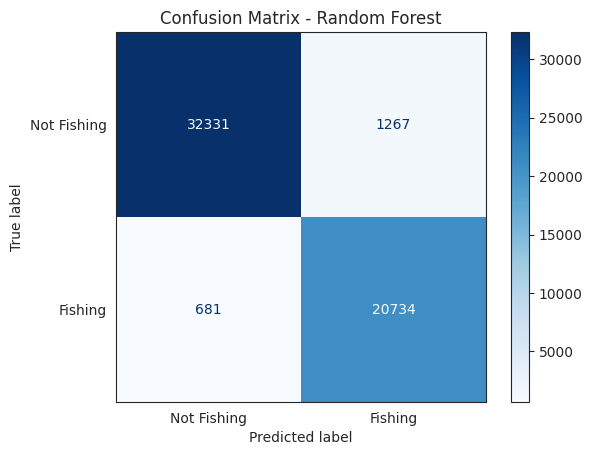

<Figure size 300x300 with 0 Axes>

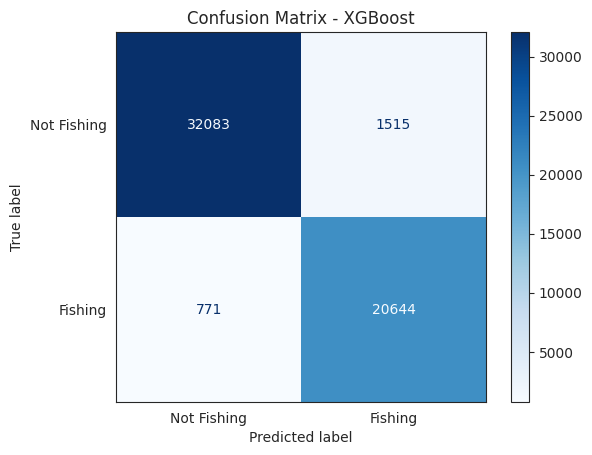

<Figure size 300x300 with 0 Axes>

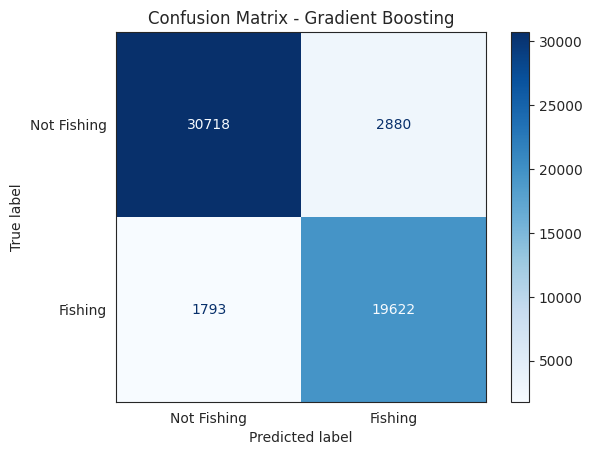

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression - Cross-validation Accuracy: 0.5766 ± 0.0233
Random Forest - Cross-validation Accuracy: 0.9683 ± 0.0010
XGBoost - Cross-validation Accuracy: 0.9606 ± 0.0015
Gradient Boosting - Cross-validation Accuracy: 0.9154 ± 0.0024


In [13]:
 ### ============== MODEL TRAINING ============== ###
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True),
    "XGBoost": XGBClassifier(n_estimators=100, eval_metric='logloss'),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} - Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

    if name == "Random Forest":
        print(f"OOB Score: {model.oob_score_:.4f}")

visualize_all(models, X_test, y_test, X.columns, df)

# Perform model selection across all models
model_selection_results = perform_model_selection(models, X, y)